In [35]:
## Include packages

using DelimitedFiles
using DCAUtils
using Statistics
using KitMSA
using FastaIO
using LinearAlgebra
using StatsBase
using PyPlot
using Random

include("../src/read_write.jl")
include("../src/energy.jl")
include("../src/msa_tools.jl")
include("../src/extra_tools.jl")
include("../src/mutability.jl")
;

In [36]:
PATH_PAR_dbd = "../data/model_parameters/Parameters_conv_Thr-PCD40.dat"
htmp, Jtmp = KitMSA.read_par_BM(PATH_PAR_dbd)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
maximum(J)
;

In [37]:
f1, f2, _ = DCAUtils.compute_weighted_frequencies(Int8.(nat_dbd'), 22, 0.2);
f1 = reshape(f1, (21,76))
f2 = reshape(f2, (21,76,21,76));
conn_corr = zeros(size(f2))
for i in 1:76
    for j in i+1:76
        for a in 1:21
            for b in 1:21
                conn_corr[a,i,b,j] = f2[a,i,b,j] - (f1[a,i]*f1[b,j])
            end
        end
    end
end

LoadError: UndefVarError: `nat_dbd` not defined

In [38]:
function compare_seq(a::Array{Int8,1}, b::Array{Int8,1})
    if a == b
        return 0
    else
        return findall(a .!= b)[1]
    end
end

function find_positions(msa)
    
    return [compare_seq(msa[j-1,:], msa[j,:]) for j in 2:length(msa[:,1])]
        
end



function get_entropy(f; q =21)
    N=length(f[1,:])
    entr = zeros(Float64, N)
    for i in 1:N
        for a in 1:q
            if(f[a,i]>0)
                entr[i]-=f[a,i]*log(f[a,i])
            end
        end
    end
    
    return entr / log(2)
end

function proba_DNA_gibbs_without_deg(k, mutated_seq, h, J, N; q = 21, T = 1)
	prob = zeros(q)
	for i in 1:q
        q_k = i
		log_proba = h[q_k, k]
 		for j in 1:N
			log_proba += J[mutated_seq[j], q_k , j, k]
        end
		prob[i] = exp(log_proba/T)
	end
	return normalize(prob,1)
    
end

function cont_dep_entr_without_deg(background, h, J; q =21, T =1)
    
    N = length(background)
    
    prob = hcat([ProbabilityWeights(proba_DNA_gibbs_without_deg(pos_mut, background, h, J, N, T=T, q=q)) for pos_mut in 1:N]...)

    return get_entropy(prob, q = q)[:]
end

function write_cde_of_chains(folder, out_path, mask, h, J, n)
    fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder))
    res = []
    for i in 1:n
        chain = Int8.(fasta2matrix(joinpath(folder_path, fasta_files[i])))[mask,:]
        cde_msa = hcat([cont_dep_entr_without_deg(chain[step,:], h, J, q= 21) 
                for step in 1:length(chain[:,1])]...)'
        push!(res, vec(cde_msa))
        if i %10 == 0
            println(i)
        end
    end
    writedlm(out_path, hcat(res...))
    return hcat(res...)
end

function cde_1site(site, background, h, J; q = 21,  T = 1)
  
    N = length(background)
    prob = ProbabilityWeights(proba_DNA_gibbs_without_deg(site, 
            background, h, J, N, T = T, q = q))
    return get_entropy(prob, q = q)
end


function cde_chain(chain, h, J)
    
    res = zeros(size(chain))
    
    res[1,:] = cont_dep_entr_without_deg(chain[1,:], h, J, q= 21)[:] 
    
    for i in 2:size(chain, 1)
        if matrices[i,:] == matrices
            res[i,:] = res[i-1, :]
        else 
            res[i,:] = cont_dep_entr_without_deg(chain[i,:], h, J, q= 21)[:]
        end
    end
    
    return res
end

function CIE(msa; q = 21)
    L = size(msa,2)
    f = reshape(DCAUtils.compute_weighted_frequencies(Int8.(msa'), q+1, 0.2)[1], (q, L))
    return get_entropy(f, q = q)
end
    

CIE (generic function with 1 method)

In [39]:
path_dbd = "../data/alignments/natural/DBD_alignment.uniref90.cov80.a2m"
nat_dbd = Int8.(fasta2matrix(path_dbd))
w_dbd = DCAUtils.compute_weights(Int8.(nat_dbd'), 0.2)[1]
;

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705


In [40]:
folder_path2 = "../../scra_data_beta/amino_mixed_dbd_steps5000000_seqs2_T1.0p0.5/equil_det_bal_dbd_silico_chain_num_1_T_1.0.mixedDNA"
@time matrices = Int8.(fasta2matrix(folder_path2))[1:50001, :]
@time pos = find_positions(matrices)
mut_times = [i for (i, val) in enumerate(pos) if val != 0]
mut_sites = [val for val in pos if val != 0]
mut_ab = [sum(mut_sites .== i) ./length(mut_sites) for i in 1:size(matrices,2)]
;

 33.637753 seconds (30.03 M allocations: 3.755 GiB, 2.88% gc time, 0.12% compilation time)
  0.159424 seconds (362.19 k allocations: 29.536 MiB, 89.00% compilation time)


In [41]:
folder_path2 = "../../scra_data_beta/seqs_ev_wtThornton_100000steps_100000stored"

function read_sequences(filename::AbstractString)
    sequences = Vector{Vector{Char}}()  # Vector of Vector{Char}
    
    # Open the file
    open(filename) do file
        for line in eachline(file)
            # Check if the line contains a sequence
            if !startswith(line, "step") && !isempty(strip(line))
                push!(sequences, collect(line))
            end
        end
    end
    
    return sequences
end

# Usage example
sequences = read_sequences(folder_path2)

matrices = Int8.(hcat([Int8.(letter2num.(seq)) for seq in sequences]...)')
@time pos = find_positions(matrices)
mut_times = [i for (i, val) in enumerate(pos) if val != 0]
mut_sites = [val for val in pos if val != 0]
mut_ab = [sum(mut_sites .== i) ./length(mut_sites) for i in 1:size(matrices,2)];
;

  0.043952 seconds (254.48 k allocations: 28.320 MiB)


In [44]:
L = 76
@time freqs_nat_gap = reshape(compute_weighted_frequencies(Int8.(nat_dbd'), 22, 0.2)[1], (21, L))
entr_nat = CIE(nat_dbd); 
cde_nat = zeros(size(nat_dbd))
for s in 1:size(cde_nat,1)
    cde_nat[s,:] = cont_dep_entr_without_deg(nat_dbd[s,:], h, J, q = 21) 
end
m_cde_nat = mean(cde_nat, weights(w_dbd), dims = 1)[:];
var_cde_nat = [var(cde_nat[:,i], weights(w_dbd)) for i in 1:76];

In [45]:
function proba_DNA_gibbs_masked(k, sites, masked_seq, h, J; q = 21, T = 1)
	prob = zeros(q)
	for i in 1:q
        q_k = i
		log_proba = h[q_k, k]
        n = 0
 		for j in sites
            n += 1
            log_proba += J[masked_seq[n], q_k , j, k]
        end
		prob[i] = exp(log_proba/T)
	end
	return normalize(prob,1)
    
end

function proba_DNA_gibbs_field(k, h, J; q = 21, T = 1)
	prob = zeros(q)
	for i in 1:q
        q_k = i
		log_proba = h[q_k, k]
		prob[i] = exp(log_proba/T)
	end
	return normalize(prob,1)
    
end

function cde_field(pos_mut, h, J; q =21, T =1)
     
    prob = ProbabilityWeights(proba_DNA_gibbs_field(pos_mut, h, J, T=T, q=q)) 

    return get_entropy(prob, q = q)[:]
end

function cde_masked(sites, masked_seq, h, J; q =21, T =1)
    
    prob = hcat([ProbabilityWeights(proba_DNA_gibbs_masked(pos_mut, sites, masked_seq, h, J, T=T, q=q)) for pos_mut in 1:N]...)

    return get_entropy(prob, q = q)[:]
end

function cde_masked(pos_mut, sites, masked_seq, h, J; q =21, T =1)

    prob = ProbabilityWeights(proba_DNA_gibbs_masked(pos_mut, sites, masked_seq, h, J, T=T, q=q))
    
    return get_entropy(prob, q = q)[:]
end



function TT(Z::Array{Int8,2},cde_nat::Array{Float64,2},
        h::Array{Float64,2},J::Array{Float64,4}, W::Array{Float64,1})
    N, L = size(Z)
    T = zeros(Float64,L,L,21)
    mcde = mean(cde_nat, weights(W), dims = 1)[:]

    for site in 1:L
        for s in 1:N
            CDE_mysite = cde_1site(site, Z[s,:], h, J, q = 21)[1] 
            for n in 1:L
                if n != site
                    T[site,n,Z[s,n]] += (CDE_mysite - mcde[site]) * W[s]
                end
            end
        end
        T[site,:,:] ./= sum(W)
    end
    return T
end


function TT_singlesite(site::Int, Z::Array{Int8,2},cde_nat::Array{Float64,2},
        h::Array{Float64,2},J::Array{Float64,4}, W::Array{Float64,1})
    N, L = size(Z)
    T = zeros(Float64,L,21)
    mcde = mean(cde_nat[:,site], weights(W), dims = 1)[1]
    #println(mcde)

    for s in 1:N
        CDE_mysite = cde_1site(site, Z[s,:], h, J, q = 21)[1] 
        #println(CDE_mysite)
        for n in 1:L
            if n != site
                T[n,Z[s,n]] += (CDE_mysite - mcde) * W[s]
            end
        end
    end
    T ./= sum(W)
    return T
end


function TTcond(site::Int, freq::Array{Float64, 2}, n_aminos::Int, Z::Array{Int8,2}, cde_nat::Array{Float64,2},
        h::Array{Float64,2},J::Array{Float64,4}, W::Array{Float64,1})
    
    L = size(Z,2)
    tcond = zeros(Float64, L, 21, L, 21)
    
    aminos = sortperm(freq[:,19], rev = true)[1:n_aminos]
    
    for aa in aminos
        idxs = Z[:,site] .== aa
        Z_red = Z[idxs, :]
        cde_red = cde_nat[idxs, :]
        _w = W[idxs]
        tcond[site, aa, : ,:] = TT_singlesite(site, Z_red, cde_red, h, J, _w)
    end   

    return tcond
end



TTcond (generic function with 1 method)

## Last part

In [164]:
wt_thornton = Int8.(readdlm("../data/alignments/refs/wt_thornton")[:]);
@time cde_wt = cont_dep_entr_without_deg(wt_thornton, h, J, q = 21) ;

  0.232440 seconds (288.88 k allocations: 19.654 MiB, 97.66% compilation time)


In [12]:
function cde_DMS(wt, h, J)
    N = length(wt)
    cde = zeros(N, 21, N)
    cde_wt = cont_dep_entr_without_deg(wt, h, J, q = 21) 
    for n in 1:N
        for a in 1:21
            seq = deepcopy(wt)
            seq[n] = a
            cde[:, a , n] = (cont_dep_entr_without_deg(seq, h, J, q = 21)) .- cde_wt
        end
    end
    return cde
end
    
@time delta_cde = cde_DMS(wt_thornton, h, J);

  1.377572 seconds (553.50 k allocations: 96.416 MiB, 14.73% gc time, 31.96% compilation time)


In [62]:
ttcond = TTcond(19, freqs_nat_gap, 4, nat_dbd, cde_nat, h, J, w_dbd); 

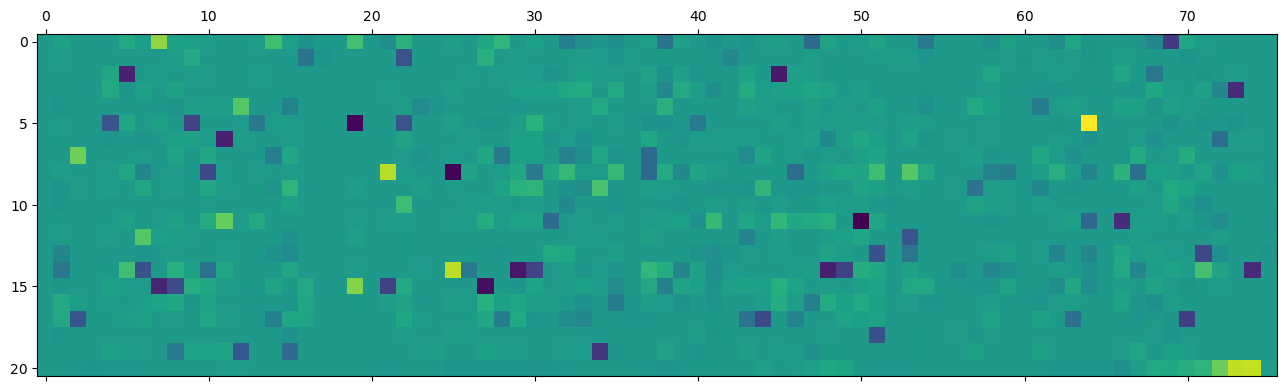

PyObject <matplotlib.image.AxesImage object at 0x7f5dc75e67f0>

In [63]:
matshow(ttcond[19, 3, :, :]')

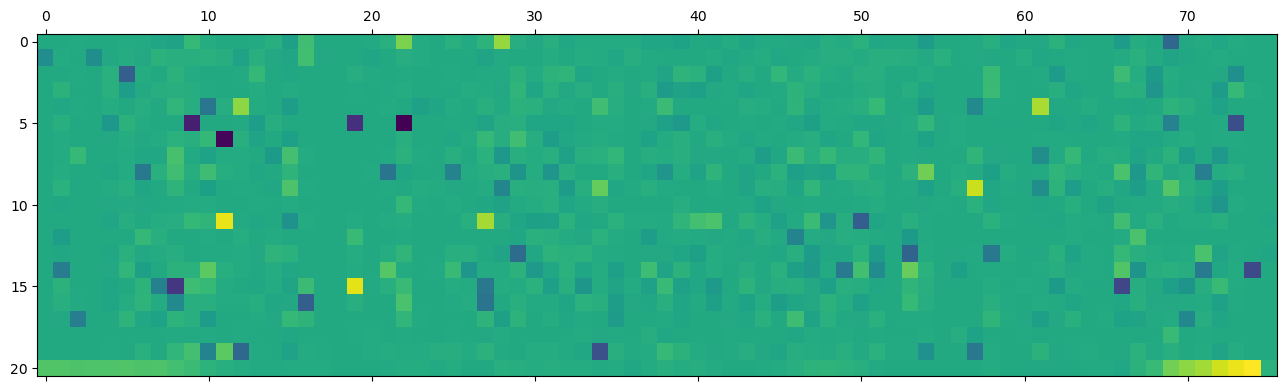

PyObject <matplotlib.image.AxesImage object at 0x7f5dc1173400>

In [64]:
matshow(ttcond[19,4,:,:]')

In [65]:
@time tt = TT(nat_dbd, cde_nat, h, J, w_dbd);

  9.041925 seconds (13.27 M allocations: 1.414 GiB, 4.32% gc time)


In [66]:
ttss = TT_singlesite(19, nat_dbd, cde_nat, h, J, w_dbd);

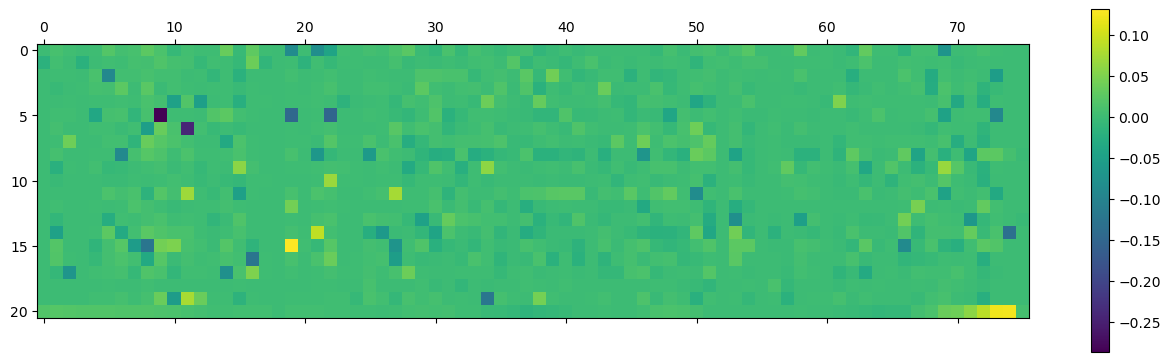

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5dc115ad00>

In [67]:
matshow(tt[19,:,:]')
colorbar()
#savefig("../sito19.png")

In [168]:
epist_ord = sortperm(abs.(entr_nat .- m_cde_nat), rev = true);
epist_score = abs.(entr_nat .- m_cde_nat)
FN = Array{Float64}(undef,L,L)
for i in 1:L
    for j in 1:L
        FN[i,j] = norm(J[:,:,i,j], 2)
    end
end

In [275]:
site = 23
aa = 16
idxs = nat_dbd[:,site] .== aa
println((m_cde_nat[site], entr_nat[site]))
mean(cde_nat[idxs, site], weights(w_dbd[idxs]))

(1.6074439296165257, 2.9297072756825484)


2.2089215266152715

In [238]:
y = zeros(76, 76)
start = time()
for site in 1:76
    contr = [maximum(abs.(tt[site,i,:])) for i in 1:size(tt,2)]
    ord = sortperm(contr, rev = true)
    N_seq = 1000
    cde_incr = zeros(N_seq, 76)
    for s in 1:N_seq
        cde_incr[s,:] = w_dbd[s] .* ([cde_masked(site, ord[1:i], nat_dbd[s,:][ord[1:i]], h, J)[1] 
            for i in 1:76] .- cde_nat[s, site]) ./ sum(w_dbd[1:N_seq])
    end
    y[site,:] = sum(cde_incr, dims = 1)[:] 
end


println(fine-start)

for i in 1:76
    plt.plot([i for i in 1:76] .* 100 ./ 76, y[epist_ord[i], :] .^2, 
        color=PyPlot.ColorMap("viridis")(abs.(entr_nat[epist_ord[i]] - m_cde_nat[epist_ord[i]])))
end

plt.ylim(0,3.)
plt.xlabel("% fixed sites")
plt.ylabel("|cde_fix_n - cde_nat|^2 (avg on nat)") 
savefig("../fig_cde.png")

LoadError: InterruptException:

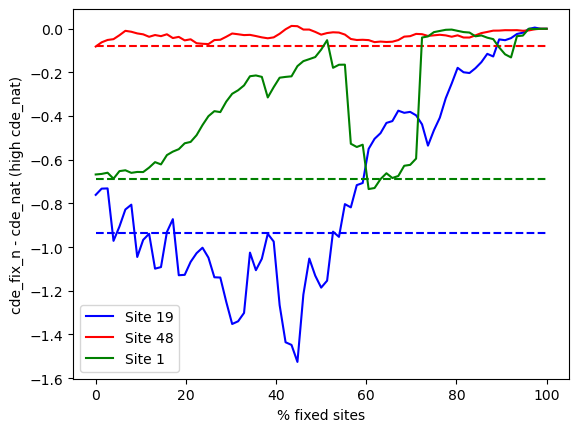

In [42]:
sites = [19,48,1]
c = ["blue", "red", "green"]
cde_incr = zeros(76, 77)
idx = 1
for site in sites
    seq_nat = argmax(cde_nat[:,site])
    #real_contr = [tt[site, i, mask_seq[i]] for i in 1:size(tt,2)]
    contr = [maximum(abs.(tt[site,i,:])) for i in 1:size(tt,2)]
    #mask_seq = Int8.([argmax(abs.(tt[site,i,:])) for i in 1:size(tt,2)])
    mask_sites = [i for i in 1:76];
    ord = sortperm(contr, rev = true)
    cde_incr[site,1] = cde_field(site, h,J)[1]  - cde_nat[seq_nat, site]  
    cde_incr[site,2:end] = ([cde_masked(site, mask_sites[ord][1:i], nat_dbd[seq_nat,:][mask_sites[ord][1:i]], h, J)[1] 
            for i in 1:76] .- cde_nat[seq_nat, site]);
    plt.plot([i for i in 0:76] .* 100 ./ 76, cde_incr[site,:], label = "Site $(site)", color = c[idx])
    plt.plot([0,100], [entr_nat[site] .- cde_nat[argmax(cde_nat[:,site]),site] for _ in 1:2],linestyle = "--", color = c[idx])
    idx += 1 
end

plt.xlabel("% fixed sites")
plt.ylabel("cde_fix_n - cde_nat (high cde_nat)") 
plt.legend()
savefig("../fig_cde_3sites_high.png")

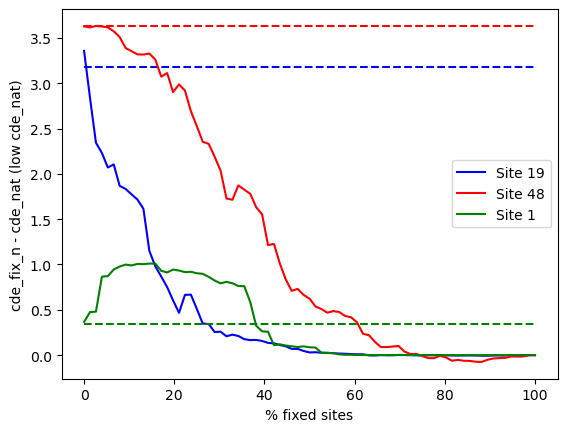

In [43]:
sites = [19, 48,1]
c = ["blue", "red", "green"]
cde_incr = zeros(76, 77)
idx = 1
for site in sites
    seq_nat = argmin(cde_nat[:,site])
    contr = [maximum(abs.(tt[site,i,:])) for i in 1:size(tt,2)]
    mask_sites = [i for i in 1:76];
    ord = sortperm(contr, rev = true)
    cde_incr[site,1] = cde_field(site, h,J)[1]  - cde_nat[seq_nat, site]  
    cde_incr[site,2:end] = ([cde_masked(site, mask_sites[ord][1:i], nat_dbd[seq_nat,:][mask_sites[ord][1:i]], h, J)[1] 
            for i in 1:76] .- cde_nat[seq_nat, site]);
    plt.plot([i for i in 0:76] .* 100 ./ 76, cde_incr[site,:], label = "Site $(site)", color = c[idx])
    plt.plot([0,100], [entr_nat[site] .- cde_nat[argmin(cde_nat[:,site]),site] for _ in 1:2],linestyle = "--", color = c[idx])
    idx += 1
end


plt.xlabel("% fixed sites")
plt.ylabel("cde_fix_n - cde_nat (low cde_nat)") 
plt.legend()
savefig("../fig_cde_3sites_low.png")

In [313]:

n_seq = size(nat_dbd,1)
cde_incr = zeros(76,76,n_seq)
#given a site, and a portion of the background, returns what is cde[site|masked_back] - cde[site|all_back]
#also returns which nat_seqs are used and their cde_back

chosen_seqs = zeros(Int, n_seq, 76)
chosen_cdes = zeros(n_seq, 76)

sites = [18,19]

for site in sites
    idx = 0
    contr = [maximum(abs.(tt[site,i,:])) for i in 1:size(tt,2)]
    ord = sortperm(contr, rev = true) #order according to saverio T
    #ord = links[site,:]
    #ord = sortperm(FN[1,:], rev = true) #order according to frobhenius norm
    #seqs = sortperm(cde_nat[:,site], rev = false)[1:n_seq] #most conserved seqs
    #seqs = sortperm(cde_nat[:,site], rev = true)[1:n_seq] #most variable seqs
    #seqs = Int.(rand(1:size(nat_dbd, 1), n_seq))  #seqs extracted at random
    for s in 1:n_seq
        idx += 1
        cde_incr[site, :,idx] = ([cde_masked(site, ord[1:i], nat_dbd[s,:][ord[1:i]], h, J)[1] 
            for i in 1:76] .- cde_nat[s, site]);
    end
    chosen_seqs[:, site] = seqs
    chosen_cdes[:, site] = cde_nat[seqs, site]
end

t = 0.3
perc_seqs = zeros(76,76) 

#for every site gives how many natural seqs converge to cde
for site in sites
    perc_seqs[site,:] = [sum([all(x -> x < t, abs.(cde_incr[site, pos:end,i])) 
            for i in 1:size(cde_incr, 3)]) * 100/size(cde_incr, 3) for pos in 1:76]    
end

t = 0.3
abund = zeros(76, n_seq)  
#given a site, returns how much of the back fixes cde[site] for each background seq, do a hist
L = size(abund,1)
for site in sites
    for s in 1:n_seq
        for pos in 1:L
            p = all(x -> x < t, abs.(cde_incr[site, pos:end,s]))
            if p == true
                abund[site, s] = pos * 100/L 
                break
            end
        end
    end                 
end

In [140]:
function CDE_masked_back(site::Int, tt::Array{Float64, 2}, nat_msa::Array{Int8,2},
        cde_nat::Array{Float64,2}, title, filename)
    n_seq = size(nat_msa,1)
    res = zeros(76, n_seq)  
    ord = sortperm([maximum(abs.(tt[i,:])) for i in 1:size(tt,1)], rev = true)
    for idx in 1:n_seq
        res[:, idx] = ([cde_masked(site, ord[1:i], nat_msa[idx,ord[1:i]], h, J)[1] 
            for i in 1:76] .- cde_nat[idx, site]);
    end
    
    for i in 1:n_seq
        plt.plot(res[:,i], alpha = 0.01, color = "black")
    end
    plt.plot(mean(res, dims = 2),linestyle = "--", color = "red", label = "mean")
    plt.plot([0,76], [0.3,0.3], linestyle = "--", color = "green", label = "tresh")
    plt.plot([0,76], [-0.3,-0.3], linestyle = "--", color = "green")
    plt.title(title)
    plt.legend()
    savefig(filename)
    
    return res
end   
    
        

CDE_masked_back (generic function with 3 methods)

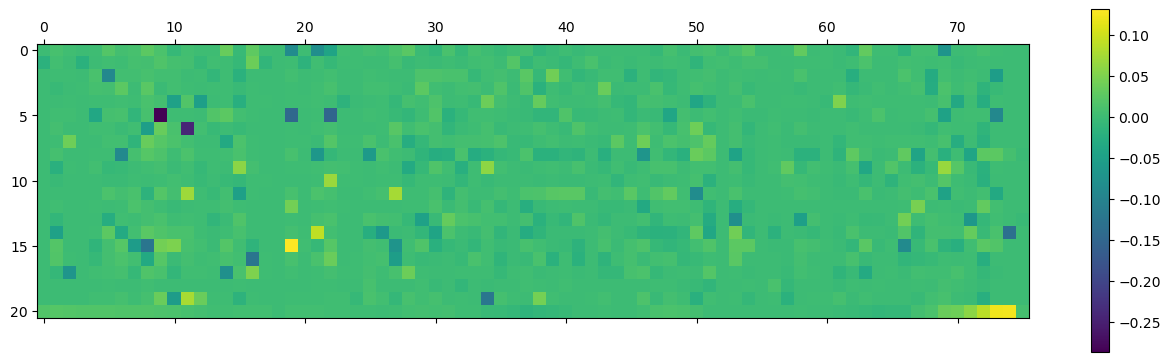

In [277]:
matshow(tt[19, :,:]')
colorbar()
savefig("../../site19T.png")

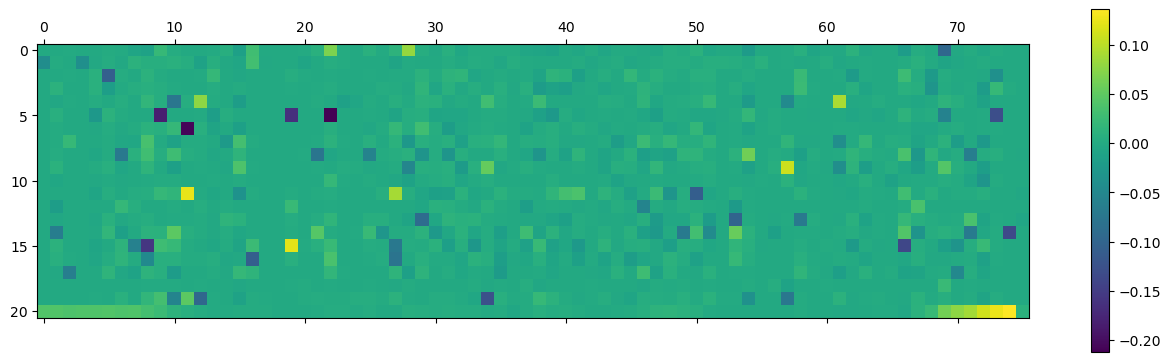

In [281]:
matshow(ttcond[19, 4,:,:]')
colorbar()
savefig("../../site19T4.png")

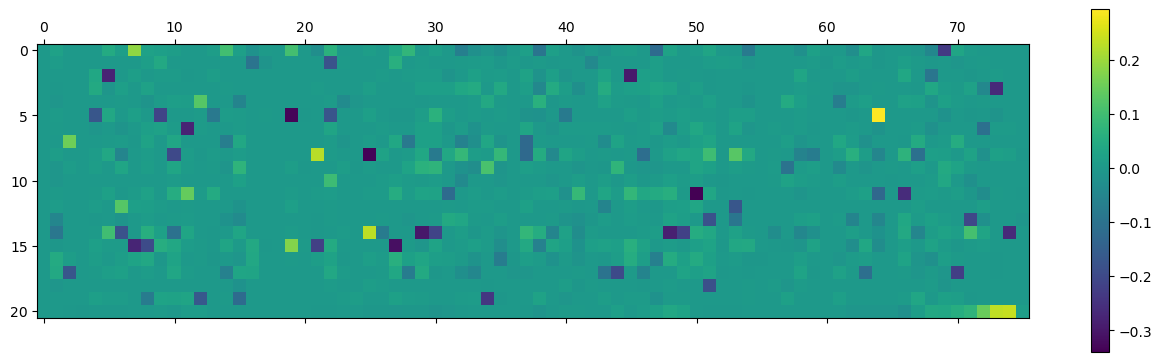

In [282]:
matshow(ttcond[19, 3,:,:]')
colorbar()
savefig("../../site19T3.png")

 34.547473 seconds (20.90 M allocations: 2.926 GiB, 1.37% gc time)


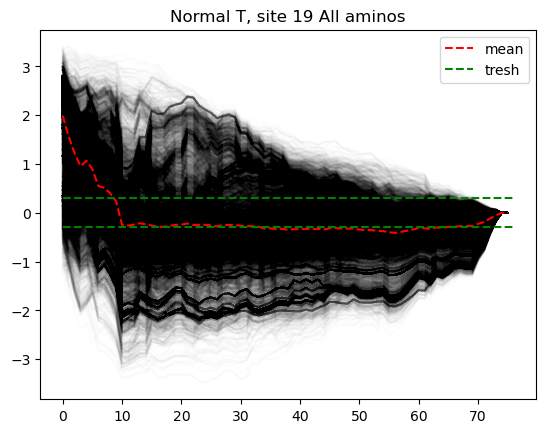

In [146]:
site = 19
title = "Normal T, site $(site) All aminos"
filename = "../NormalTsite$(site)allaminos.png"
@time res = CDE_masked_back(site, tt[site,:,:], nat_dbd, cde_nat, title, filename);

  3.620823 seconds (2.03 M allocations: 274.037 MiB, 4.67% gc time, 5.75% compilation time)


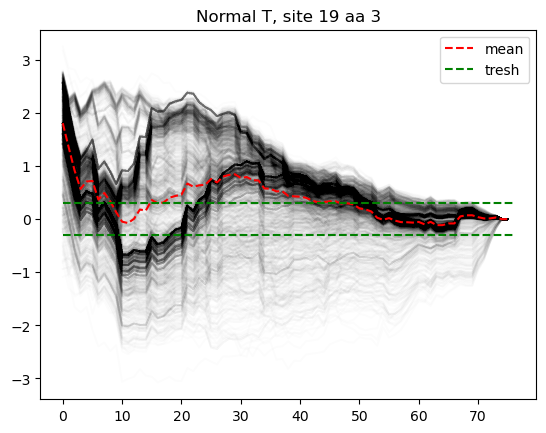

In [141]:
aa = 3
site = 19
idxs = nat_dbd[:,site] .== aa
nat_red = nat_dbd[idxs, :]
cde_red = cde_nat[idxs,:]
title = "Normal T, site $(site) aa $(aa)"
filename = "../NormalTsite$(site)aa$(aa).png"
@time res = CDE_masked_back(site, tt[site,:,:], nat_red, cde_red, title, filename);

 24.373868 seconds (14.23 M allocations: 1.993 GiB, 1.41% gc time)


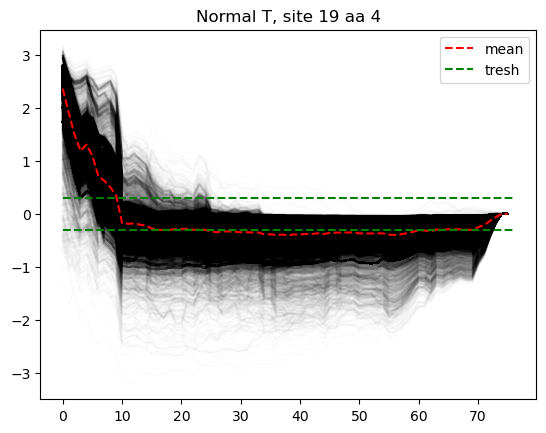

In [142]:
aa = 4
site = 19
idxs = nat_dbd[:,site] .== aa
nat_red = nat_dbd[idxs, :]
cde_red = cde_nat[idxs,:]

title = "Normal T, site $(site) aa $(aa)"
filename = "../NormalTsite$(site)aa$(aa).png"
@time res = CDE_masked_back(site, tt[site,:,:], nat_red, cde_red, title, filename);

  3.166903 seconds (1.89 M allocations: 264.854 MiB, 4.87% gc time)


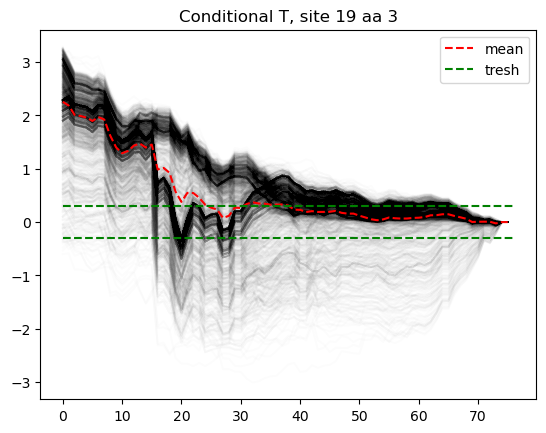

In [143]:
aa = 3
site = 19
idxs = nat_dbd[:,site] .== aa
nat_red = nat_dbd[idxs, :]
cde_red = cde_nat[idxs,:]

title = "Conditional T, site $(site) aa $(aa)"
filename = "../ConditionalTsite$(site)aa$(aa).png"
@time res = CDE_masked_back(site, ttcond[site, aa, :, :], nat_red, cde_red, title, filename);

 24.562463 seconds (14.27 M allocations: 1.994 GiB, 1.68% gc time)


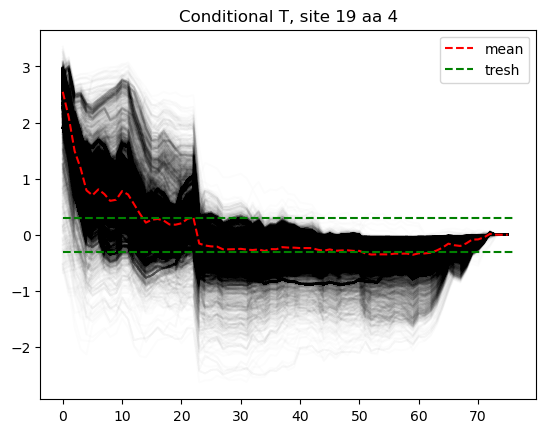

In [144]:
aa = 4
site = 19
idxs = nat_dbd[:,site] .== aa
nat_red = nat_dbd[idxs, :]
cde_red = cde_nat[idxs,:]
title = "Conditional T, site $(site) aa $(aa)"
filename = "../ConditionalTsite$(site)aa$(aa).png"
@time res = CDE_masked_back(site, ttcond[site, aa, :, :], nat_red, cde_red, title, filename);

In [284]:
aa = 3
site = 19
idxs = nat_dbd[:,site] .== aa
nat_red = nat_dbd[idxs, :]
cde_red = cde_nat[idxs,:]
diffCIE = CIE(nat_red) .- entr_nat
diffCIE[site] = 0;

θ = 0.2 threshold = 15.0
M = 2198 N = 76 Meff = 243.85877273591552


In [365]:
freq_fix = reshape(DCAUtils.compute_weighted_frequencies(Int8.(nat_red'), 22, 0.2)[1], (21, 76)) 
diff_freq = freq_fix .- freqs_nat_gap;
#diff_freq[:, site] .= 0;

θ = 0.2 threshold = 15.0
M = 2198 N = 76 Meff = 243.85877273591552


In [359]:
ord_ttcond = sortperm([maximum(abs.(ttcond[19,3,i,:])) for i in 1:size(tt,1)], rev = true)[1:20]
ord_CIE = sortperm(abs.(diffCIE), rev = true)[1:20];
ord_freq = sortperm([maximum(abs.(diff_freq[:,i])) for i in 1:size(diff_freq, 2)], rev = true)[1:20]
common_sites = intersect(ord_CIE, ord_ttcond, ord_freq);
common_aminos = [argmax(abs.(ttcond[19,3,i,:]))[1] for i in common_sites];

In [326]:
common_sites

9-element Vector{Int64}:
  6
 51
 30
 65
 46
 74
 28
 20
 70

In [327]:
common_aminos

9-element Vector{Int64}:
  3
 12
 15
  6
  3
  4
 16
  6
  1

In [1]:
function recursivefind!(J::Array{Float64,4},threshold::Float64, coup_set::Array{Tuple{Int,Int},1},value::Int,site::Int,L::Int;q::Int=21)

    cand = [(i,ai) for i in 1:L for ai in 1:q if J[value,ai,site,i] > threshold]
    new_cand = [couple for couple in cand if !(couple in coup_set)]
    if length(new_cand) == 0
        return coup_set
    else
        coup_set = vcat(coup_set, new_cand)
        for couple in new_cand
            coup_set = recursivefind!(J,threshold,coup_set,couple[2],couple[1],L,q)
        end
    end
    return coup_set
end

recursivefind! (generic function with 1 method)

In [127]:
epist_ord[1:10]

10-element Vector{Int64}:
 19
 70
 23
 74
 72
 51
 73
 71
  9
 20

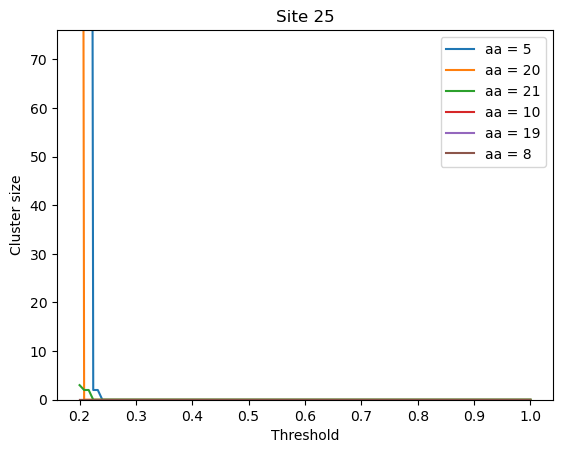

PyObject <matplotlib.legend.Legend object at 0x7f5dc53581f0>

In [131]:
n_points = 100

site = 25
aa_site = sortperm(freqs_nat_gap[:,site], rev = true)
x = range(0.2,1, n_points)
for aa in aa_site[1:6]
    n_coup = []
    for t in x
        coup_set = Tuple{Int, Int}[]
        res = recursivefind!(J, t, coup_set, aa, site, 76, 21)
        #println(res)
        push!(n_coup, length(res))
    end
    plt.plot(x, n_coup, label = "aa = $aa")
end
plt.ylim(0,76)
plt.title("Site $(site)")
plt.xlabel("Threshold")
plt.ylabel("Cluster size")
plt.legend()
        
    

In [134]:
coup_set = Tuple{Int, Int}[]
res = recursivefind!(J, 0.57, coup_set, 4, 19, 76, 21)

9-element Vector{Tuple{Int64, Int64}}:
 (9, 16)
 (10, 6)
 (22, 9)
 (74, 6)
 (19, 4)
 (8, 16)
 (17, 17)
 (67, 16)
 (72, 9)

## Dkl order

In [135]:
function loc_softmax(x, temp)
    max_ = maximum(x)
    out = zeros(size(x))
    if all(isfinite, max_)
        @fastmath out .= exp.(x .- max_)
    else
        _zero, _one, _inf = 0, 1, Inf
        @fastmath @. out = ifelse(isequal(max_,_inf), ifelse(isequal(x,_inf), _one, _zero), exp(x - max_))
    end
    #tmp = dims isa Colon ? sum(out) : sum!(max_, out)
    out .= (out).^(1/temp)
    out ./= sum(out)#tmp
    return out
end 

function DklAdd(site, seq, h, J, L; version = "Leo")
    p = zeros(L,21)
    q = exp.(h[:,site]) ./ sum(exp.(h[:,site]))
    dkl = zeros(L)
    ord = []
    cdes = []
    for k in 1:L
        if k !== site
            p[k,:] = proba_DNA_gibbs_masked(site,[k],seq[k],h,J)
            dkl[k] = kldivergence(p[k,:], q)
        end
    end
    push!(ord, argmax(dkl))
    push!(cdes, get_entropy(p[argmax(dkl), :])[1])
    if version == "Leo"
        q .= p[argmax(dkl), :]
    end
    p .= 0
    dkl .= 0
    
    for n in 2:L-1
        for k in 1:L
            if k !== site && !(k in ord)
                p[k,:] = proba_DNA_gibbs_masked(site,vcat(ord,k),seq[vcat(ord,k)],h,J)
                dkl[k] = kldivergence(p[k,:], q)
            end
        end    
        push!(ord, argmax(dkl))
        push!(cdes, get_entropy(p[argmax(dkl), :])[1])
        if version == "Leo"
            q .= p[argmax(dkl), :]
        end
        p .= 0
        dkl .= 0
    end
    return ord, cdes
end 


function cde_decrease(site, seq, h, J, L; version = "Leo")
    p = zeros(L,21)
    cde = zeros(L)
    ord = []
    ps = zeros(L-1, 21)
    cdes = []
    for k in 1:L
        if k !== site
            p[k,:] = proba_DNA_gibbs_masked(site,[k],seq[k],h,J)
            cde[k] = get_entropy(p[k,:])[1]
        end
    end
    cde[site] = 10
    cde[ord] .= 10
    push!(ord, argmin(cde))
    push!(cdes, minimum(cde))
    ps[1,:] .= p[argmin(cde),:]
    p .= 0
    cde .= 0
    
    for n in 2:L-1
        for k in 1:L
            if k !== site && !(k in ord)
                p[k,:] = proba_DNA_gibbs_masked(site,vcat(ord,k),seq[vcat(ord,k)],h,J)
                cde[k] = get_entropy(p[k,:])[1]
            end
        end   
        cde[site] = 10
        cde[ord] .= 10
        push!(ord, argmin(cde))
        push!(cdes, minimum(cde))
        ps[n,:] .= p[argmin(cde),:]
        p .= 0
        cde .= 0
    end
    return ps, cdes
end 
    
function pathDkl(final_aa, site, seq, h, J, L; mult_loss = true, best = true, temp = 0.1, reg_E = 0.1)
    p = zeros(21)
    q = zeros(21)
    q[final_aa] = 1.
    pseudocount1!(q,q,10^-4,21)
    dkl = 10^8 .* ones(L, 21)
    dE = 10^8 .* ones(L, 21)
    wt_dEs = []
    single_dEs = []
    seqs = zeros(Int, L, L)
    aas = []
    sites = []
    for i in 1:L
        seqs[i,1] = seq[i]
    end
    cdes = [cde_1site(site, seq, h, J)[1]]
    
    seqs[:,1] .= seq
    
    for n in 2:L
        for k in 1:L
            if k !== site
                for aa in 1:21
                    new_seq = deepcopy(seqs[:,n-1])
                    new_seq[k] = aa
                    p .= proba_DNA_gibbs_without_deg(site,new_seq,h,J,L)
                    pseudocount1!(p,p,10^-4,21)
                    dkl[k,aa] = kldivergence(p, q)
                    if mult_loss == true
                        dE[k,aa] = delta_energy(h,J, new_seq, seq)
                    else
                        dE[k,aa] = delta_energy(h,J, new_seq, seqs[:,n-1])
                    end
                end
            end
        end
        
        if best == true 
            i, amino = Tuple(argmin(dkl .+ (reg_E .* dE .* dE)))
        else
            cost = (dkl .+ (reg_E .* dE .* dE))
            idx = sample(1:L*21, weights(loc_softmax(.-cost, temp)))
            i = mod(idx, L)
            if i == 0
                i = 76
            end
            amino = div(idx,L)+1
            if amino == 22
                amino = 21
            end
        end
        seqs[:,n] .= seqs[:,n-1]
        seqs[Int(i), n] = Int(amino)
        push!(cdes, cde_1site(site,seqs[:,n], h, J)[1])
        push!(aas, amino)
        push!(sites,i)
        push!(single_dEs, delta_energy(h, J, seqs[:,n], seqs[:,n-1]))
        push!(wt_dEs, delta_energy(h, J, seqs[:,n], seq))
        dkl .= 10^8
    end 
    
    return seqs, cdes, aas, sites, single_dEs, wt_dEs
end 

function pseudocount1!(dest, f1, pc::AbstractFloat, q::Int)
     dest .= ((1-pc) .* f1 ) .+ (pc / q)
end


pseudocount1! (generic function with 1 method)

In [47]:
function profpathDkl(target_aa, site, seq, nat_dbd, cde_nat, h, J, L; mult_loss = true, reg_E = 0.1)
    p = zeros(21)
    q = zeros(21)
    sub_msa = nat_dbd[(cde_nat[:, site] .< 1.) .&& (nat_dbd[:,site] .== target_aa), :]
    sub_f = reshape(compute_weighted_frequencies(Int8.(seqs3'), 22, 0.2)[1], (21, L))
    q[target_aa] = 1.
    pseudocount1!(sub_f,sub_f,10^-4,21)
    losses = []
    loss = zeros(L, 21)
    loss[site,:] .= 10^8
    dE = zeros(L, 21)
    wt_dEs = []
    single_dEs = []
    seqs = zeros(Int, L, L)
    aas = []
    sites = []
    for i in 1:L
        seqs[i,1] = seq[i]
    end
    cdes = [cde_1site(site, seq, h, J)[1]]
    dkls = []
    
    seqs[:,1] .= seq
    
    for n in 2:L
        for k in 1:L
            if k !== site
                for aa in 1:21
                    new_seq = deepcopy(seqs[:,n-1])
                    new_seq[k] = aa
                    for pos in 1:L
                        p .= proba_DNA_gibbs_without_deg(site,new_seq,h,J,L)
                        pseudocount1!(p,p,10^-4,21)
                        loss[k,aa] += kldivergence(p, sub_f[:,site])
                    end
                    if mult_loss == true
                        dE[k,aa] = delta_energy(h,J, new_seq, seq)
                    else
                        dE[k,aa] = delta_energy(h,J, new_seq, seqs[:,n-1])
                    end
                end
            end
        end
        loss .+= (reg_E .* dE .* dE)
        i, amino = Tuple(argmin(loss))
        seqs[:,n] .= seqs[:,n-1]
        seqs[Int(i), n] = Int(amino)
        #push!(cdes, cde_1site(site,seqs[:,n], h, J)[1])
        push!(losses, loss[i, amino])
        push!(aas, amino)
        push!(sites,i)
        push!(single_dEs, delta_energy(h, J, seqs[:,n], seqs[:,n-1]))
        push!(wt_dEs, delta_energy(h, J, seqs[:,n], seq))
        loss .= 0
        loss[site,:] .= 10^8
    end 
    
    return seqs, cdes, aas, sites, dkls, single_dEs, wt_dEs
end 

profpathDkl (generic function with 1 method)

In [150]:
seqs3 = nat_dbd[(cde_nat[:, site] .< 1.) .&& (nat_dbd[:,site] .== target_aa), :];

θ = 0.2 threshold = 15.0
M = 1039 N = 76 Meff = 74.71297667173316
 40.946918 seconds (28.12 M allocations: 6.035 GiB, 1.22% gc time)


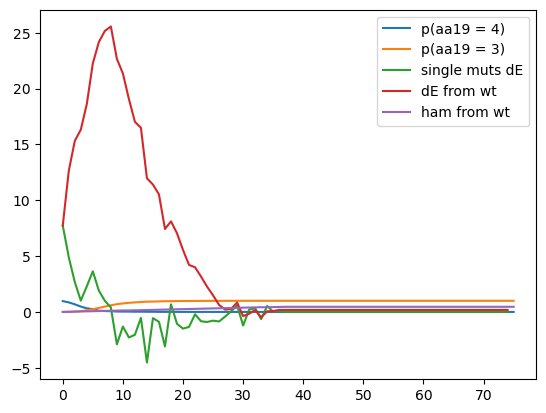

In [511]:
site = 19
L = 76
start_aa = 4
target_aa = 3
seq = nat_dbd[10,:]
reg_E = 0.1
mult_loss = true

@time seqs, cdes, aas, sites, dkls, single_dEs, wt_dEs = profpathDkl(target_aa, site,  
    seq, nat_dbd, cde_nat, h, J, L, mult_loss =  mult_loss, reg_E = reg_E)
ps = hcat([proba_DNA_gibbs_without_deg(site, seqs[:,i], h,J,L) for i in 1:L]...)
dist = count_muts_msa(Int8.(seqs'), seq) ./L
plt.plot(ps[4,:], label = "p(aa19 = 4)")
plt.plot(ps[target_aa,:], label = "p(aa19 = $(target_aa))")
plt.plot(single_dEs, label = "single muts dE")
plt.plot(wt_dEs, label = "dE from wt")
plt.plot(dist, label = "ham from wt")
plt.legend()
#plt.title("Loss on Dkl + dE from wt")
savefig("../profile_transition_path_dEfromwt.png")

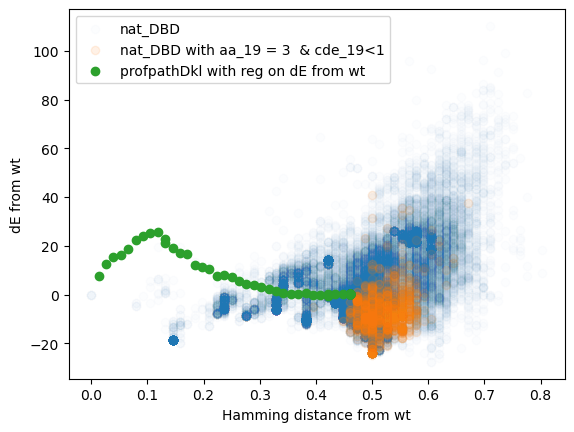

In [518]:
dist_dbd = count_muts_msa(nat_dbd, seq) ./ L
delta_ens_dbd = [delta_energy(h, J, nat_dbd[i,:], seq) for i in 1:size(nat_dbd,1)]
sub_delta_ens_dbd = [delta_energy(h, J, seqs3[i,:], seq) for i in 1:size(seqs3,1)]
sub_dist_dbd = count_muts_msa(seqs3, seq) ./ L
plt.scatter(dist_dbd, delta_ens_dbd, label = "nat_DBD", alpha = 0.01)
plt.scatter(sub_dist_dbd, sub_delta_ens_dbd, label = "nat_DBD with aa_19 = 3  & cde_19<1", alpha = 0.1)
plt.scatter(dist[2:end], wt_dEs, label = "profpathDkl with reg on dE from wt")
plt.xlabel("Hamming distance from wt")
plt.ylabel("dE from wt")
plt.legend()
savefig("../profile_trans_path_hamvsen.png")

In [516]:
println([minimum(count_muts_msa(nat_dbd,seqs[:,n])) for n in 1:size(seqs,2)])

Int16[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 20, 19, 19, 18, 18, 17, 17, 18, 18, 18, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]


In [215]:
sortperm(freqs_nat_gap[:,23])

21-element Vector{Int64}:
  5
 19
 20
 13
 15
 21
  7
  3
 14
 12
 10
  4
  2
  9
  8
 18
 11
 17
 16
  6
  1

In [216]:
cde_nat[:,23]

24944-element Vector{Float64}:
 1.9521512804410572
 1.9521512804410572
 0.3414147983197057
 0.3414147983197057
 0.3414147983197057
 0.565595003502754
 2.2083038893824916
 1.0593422618091728
 0.5580002849586592
 0.1948422257722266
 0.1948422257722266
 0.6460654855368632
 0.6170098645108083
 ⋮
 1.910257830290538
 1.910257830290538
 1.1859710298611308
 0.4443131844284368
 0.6644744477926987
 1.5391593038071822
 1.4592975966161272
 1.4158387114709872
 0.7129902544307476
 0.11674143134915645
 1.2790544331962908
 0.28034437192728323

In [220]:
count_muts_msa(seqs', seq)

76-element Vector{Int16}:
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
  ⋮
 28
 28
 28
 28
 28
 28
 28
 28
 28
 28
 28
 28

In [217]:
entr_nat[23]

2.9297072756825484

  2.251611 seconds (1.42 M allocations: 427.725 MiB, 6.46% gc time)


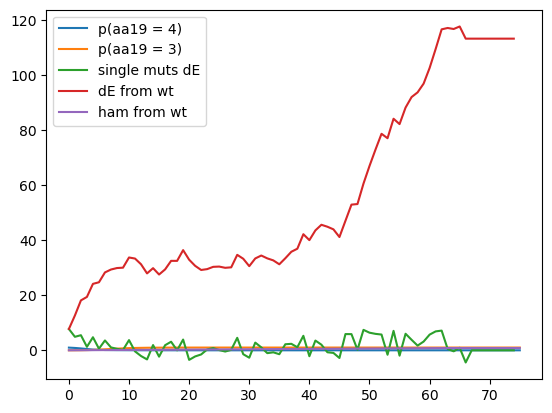

PyObject <matplotlib.legend.Legend object at 0x7fe60461c040>

In [229]:
site = 19
L = 76
start_aa = 4
target_aa = 3
seq = nat_dbd[10,:]
reg_E = 0.
mult_loss = true
best = true

@time seqs, cdes, aas, sites, dkls, single_dEs, wt_dEs = pathDkl(target_aa, site,  
    seq, h, J, L, mult_loss =  mult_loss, reg_E = reg_E, best = best)
ps = hcat([proba_DNA_gibbs_without_deg(site, seqs[:,i], h,J,L) for i in 1:L]...)
dist = count_muts_msa(Int8.(seqs'), seq) ./L
plt.plot(ps[4,:], label = "p(aa19 = 4)")
plt.plot(ps[target_aa,:], label = "p(aa19 = $(target_aa))")
plt.plot(single_dEs, label = "single muts dE")
plt.plot(wt_dEs, label = "dE from wt")
plt.plot(dist, label = "ham from wt")
plt.legend()
#plt.title("Loss on Dkl + dE from wt")
#savefig("../transition_path_dEfromwt.png")

In [222]:
count_muts_msa(seqs', seq)

76-element Vector{Int16}:
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
  ⋮
 63
 63
 63
 63
 63
 63
 63
 63
 63
 63
 63
 63

In [226]:
println(aas)

Any[1, 16, 12, 4, 19, 9, 12, 15, 2, 15, 11, 18, 16, 3, 20, 15, 6, 6, 9, 5, 1, 18, 16, 2, 18, 9, 3, 15, 8, 12, 8, 19, 12, 20, 10, 7, 7, 5, 5, 16, 1, 21, 16, 15, 3, 6, 8, 16, 10, 10, 18, 6, 21, 15, 5, 16, 21, 21, 17, 12, 16, 6, 11, 8, 9, 3, 21, 1, 1, 1, 1, 1, 1, 1, 1]


In [227]:
println(sites)

Any[22, 10, 67, 74, 52, 11, 65, 49, 17, 30, 72, 45, 22, 46, 9, 31, 2, 15, 26, 35, 48, 44, 39, 23, 47, 68, 40, 41, 3, 32, 38, 70, 69, 16, 63, 73, 33, 13, 58, 60, 64, 1, 55, 42, 59, 5, 24, 43, 34, 71, 50, 53, 27, 7, 4, 8, 56, 37, 62, 14, 21, 18, 57, 36, 27, 32, 4, 48, 48, 48, 48, 48, 48, 48, 48]


In [228]:
unique(sites)

63-element Vector{Any}:
 22
 10
 67
 74
 52
 11
 65
 49
 17
 30
 72
 45
 46
  ⋮
 27
  7
  4
  8
 56
 37
 62
 14
 21
 18
 57
 36

In [144]:
site = 19
L = 76
start_aa = 4
target_aa = 3
seq = nat_dbd[10,:]
reg_E = 0.1
mult_loss = true
best = false
temp = 0.1


tot_seqs = []
ps4 = []
ps3 = []
tot_dist = []
tot_dE = []
tot_single_dE = []


for i in 1:100
    seqs, cdes, aas, sites, single_dEs, wt_dEs = pathDkl(target_aa, site,  
        seq, h, J, L, mult_loss = mult_loss, reg_E = reg_E, best = best, temp = temp)
    ps = hcat([proba_DNA_gibbs_without_deg(site, seqs[:,i], h,J,L) for i in 1:L]...)
    dist = count_muts_msa(Int8.(seqs'), seq) ./L
    push!(tot_seqs, seqs)
    push!(ps4, ps[4,:])
    push!(ps3, ps[target_aa,:])
    push!(tot_dist, dist)
    push!(tot_dE, wt_dEs)
    push!(tot_single_dE, single_dEs)
    #plt.plot(ps[4,:], color = "red", label = "p(aa19 = 4)")
    #plt.plot(ps[target_aa,:], color = "blue", label = "p(aa19 = $(target_aa))")
    #plt.plot(single_dEs, label = "single muts dE")
    #plt.plot(wt_dEs, color = "green",label = "dE from wt")
end
#plt.plot(dist, label = "ham from wt")
#plt.legend()
#plt.title("Loss on Dkl + dE from wt")
#savefig("../transition_path_dEfromwt.png")

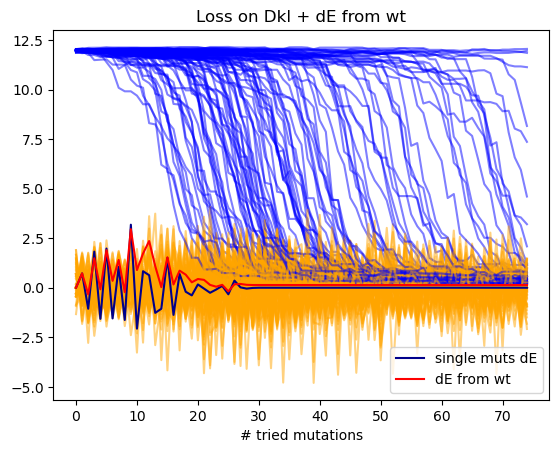

In [169]:
for i in 1:100  
    #plt.plot(ps4[i], color = "red", alpha = 0.1, label = "p(aa19 = 4)")
    #plt.plot(ps3[i], color = "blue", alpha = 0.1, label = "p(aa19 = $(target_aa))")
    plt.plot(tot_single_dE[i], color = "blue", alpha = 0.5)
    plt.plot(tot_dE[i], color = "orange",alpha = 0.5)
end
#plt.plot(ps[4,:], label = "p(aa19 = 4)")
#plt.plot(ps[target_aa,:], label = "p(aa19 = $(target_aa))")
plt.plot(single_dEs, color = "darkblue", label = "single muts dE")
plt.plot(wt_dEs, color = "red", label = "dE from wt")

plt.legend()
plt.title("Loss on Dkl + dE from wt")
plt.xlabel("# tried mutations")
savefig("../sample_trans_path_dEfromwt.png")

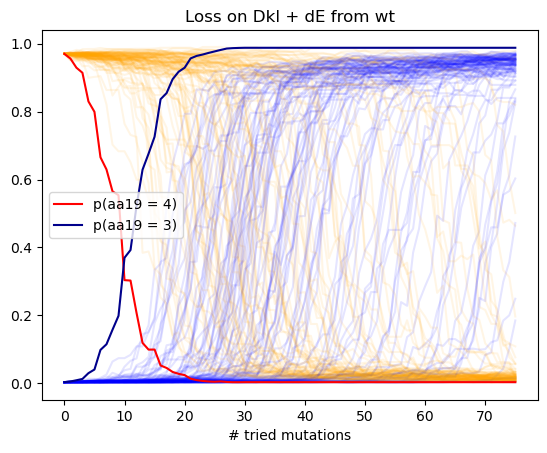

In [176]:
for i in 1:100  
    plt.plot(ps4[i], color = "orange", alpha = 0.1)
    plt.plot(ps3[i], color = "blue", alpha = 0.1)
end
plt.plot(ps[4,:], color = "red", label = "p(aa19 = 4)")
plt.plot(ps[target_aa,:],color = "darkblue", label = "p(aa19 = $(target_aa))")

plt.xlabel("# tried mutations")
plt.legend()
plt.title("Loss on Dkl + dE from wt")
savefig("../sample_probs_trans_path_dEfromwt.png")

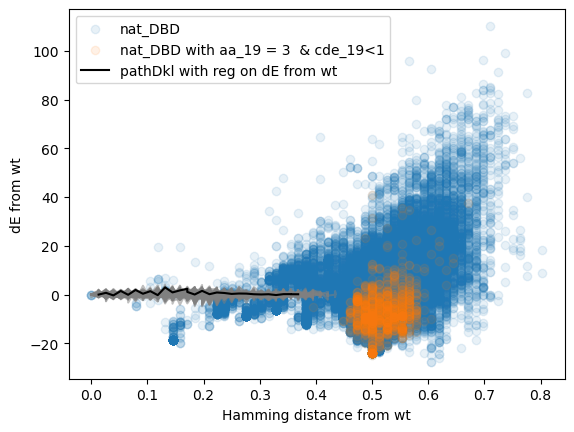

In [182]:
dist_dbd = count_muts_msa(nat_dbd, seq) ./ L
delta_ens_dbd = [delta_energy(h, J, nat_dbd[i,:], seq) for i in 1:size(nat_dbd,1)]
sub_delta_ens_dbd = [delta_energy(h, J, seqs3[i,:], seq) for i in 1:size(seqs3,1)]
sub_dist_dbd = count_muts_msa(seqs3, seq) ./ L

plt.scatter(dist_dbd, delta_ens_dbd, label = "nat_DBD", alpha = 0.1)
plt.scatter(sub_dist_dbd, sub_delta_ens_dbd, label = "nat_DBD with aa_19 = 3  & cde_19<1", alpha = 0.1)
for i in 1:100
    plt.plot(tot_dist[i][2:end], tot_dE[i], color = "grey", alpha = 0.5)
end
plt.plot(dist[2:end], wt_dEs, color = "black",label = "pathDkl with reg on dE from wt")
plt.xlabel("Hamming distance from wt")
plt.ylabel("dE from wt")
plt.legend()
savefig("../sample_trans_path_hamvsen.png")

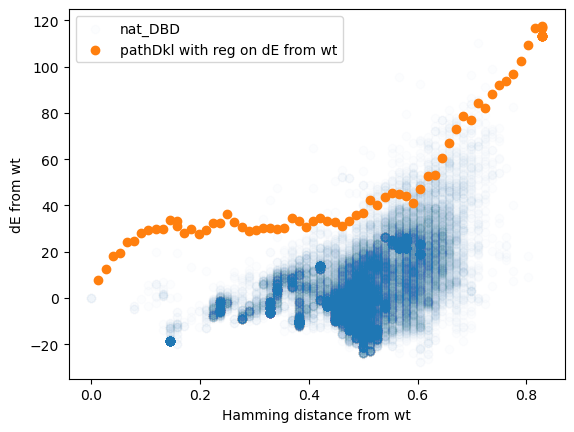

PyObject <matplotlib.legend.Legend object at 0x7fe6046f2df0>

In [230]:
dist_dbd = count_muts_msa(nat_dbd, seq) ./ L
delta_ens_dbd = [delta_energy(h, J, nat_dbd[i,:], seq) for i in 1:size(nat_dbd,1)]
plt.scatter(dist_dbd, delta_ens_dbd, label = "nat_DBD", alpha = 0.01)
plt.scatter(dist[2:end], wt_dEs, label = "pathDkl with reg on dE from wt")
plt.xlabel("Hamming distance from wt")
plt.ylabel("dE from wt")
plt.legend()
#savefig("../trans_path_hamvsen.png")

In [17]:
PATH_PAR_dbd = "../../scra_data_beta/Parameters_conv_actDBD0.98.dat"
htmp, Jtmp = KitMSA.read_par_BM(PATH_PAR_dbd)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
maximum(J)
;

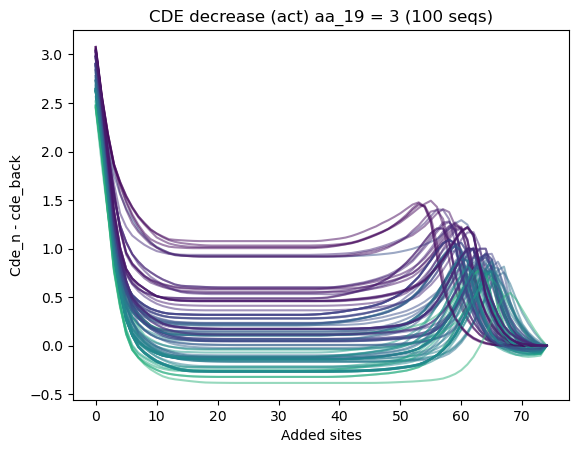

In [30]:
n_seq = 100
site = 19
aa = 3
L = length(wt_thornton)

tot_ps3 = zeros(n_seq, L-1, 21)
tot_cdes3 = zeros(n_seq, L-1)
for n in 1:n_seq
    seq = nat_dbd[(cde_nat[:, site] .< 0.8) .&& (nat_dbd[:,site] .== aa), :][n,:]
    ps, cdes = cde_decrease(site, seq, h, J, L)
    tot_ps3[n,:,:] .= ps
    tot_cdes3[n,:] .= cdes
    plt.plot(cdes .- cde_nat[(cde_nat[:, site] .< 0.8) .&& (nat_dbd[:,site] .== aa),site][n], alpha = 0.5, 
        color=PyPlot.ColorMap("viridis")(cde_nat[(cde_nat[:, site] .< 0.8) .&& (nat_dbd[:,site] .== aa),site][n]))
end
plt.xlabel("Added sites")
plt.ylabel("Cde_n - cde_back")
plt.title("CDE decrease (act) aa_$(site) = $(aa) ($(n_seq) seqs)")
savefig("../cde_decr_act_$(site)_$(aa)_$(n_seq)seqs.png")

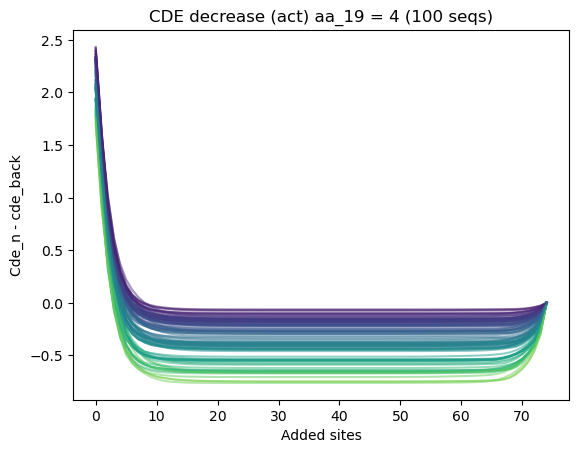

In [31]:
n_seq = 100
site = 19
aa = 4
L = length(wt_thornton)

tot_ps4 = zeros(n_seq, L-1, 21)
tot_cdes4 = zeros(n_seq, L-1)
for n in 1:n_seq
    seq = nat_dbd[(cde_nat[:, site] .< 0.8) .&& (nat_dbd[:,site] .== aa), :][n,:]
    ps, cdes = cde_decrease(site, seq, h, J, L)
    tot_ps4[n,:,:] .= ps
    tot_cdes4[n,:] .= cdes
    plt.plot(cdes .- cde_nat[(cde_nat[:, site] .< 0.8) .&& (nat_dbd[:,site] .== aa),site][n], alpha = 0.5, 
        color=PyPlot.ColorMap("viridis")(cde_nat[(cde_nat[:, site] .< 0.8) .&& (nat_dbd[:,site] .== aa),site][n]))
end
plt.xlabel("Added sites")
plt.ylabel("Cde_n - cde_back")
plt.title("CDE decrease (act) aa_$(site) = $(aa) ($(n_seq) seqs)")
savefig("../act_cde_decr$(site)_$(aa)_$(n_seq)seqs.png")

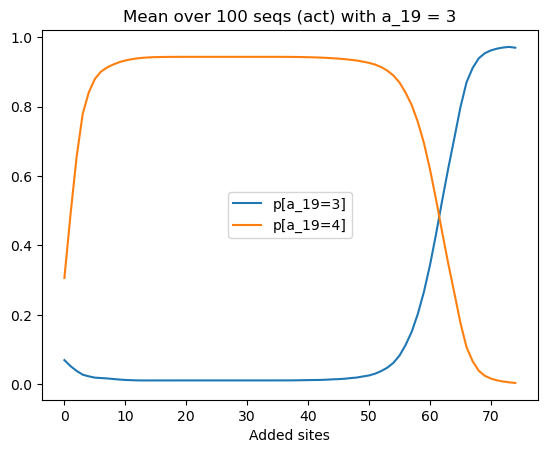

In [36]:
plt.plot(mean(tot_ps3[:,:,3],dims = 1)[:], label = "p[a_19=3]")
plt.plot(mean(tot_ps3[:,:,4], dims = 1)[:], label = "p[a_19=4]")
plt.xlabel("Added sites")
plt.legend()
plt.title("Mean over 100 seqs (act) with a_19 = 3")
savefig("../act_probs_a19_3.png")

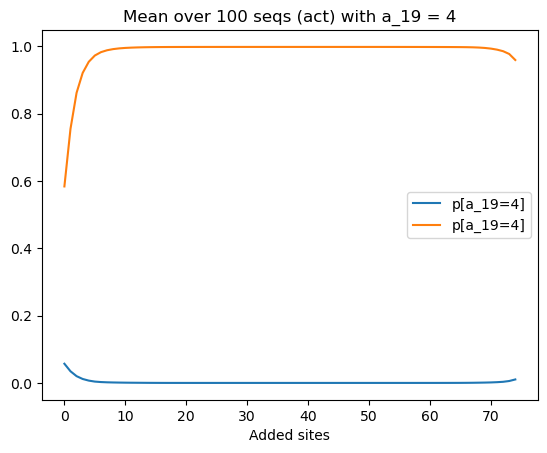

In [37]:
plt.plot(mean(tot_ps4[:,:,3], dims = 1)[:], label = "p[a_19=4]")
plt.plot(mean(tot_ps4[:,:,4], dims = 1)[:], label = "p[a_19=4]")
plt.xlabel("Added sites")
plt.legend()
plt.title("Mean over 100 seqs (act) with a_19 = 4")
savefig("../act_probs_a19_4.png")

## Saverio functions

In [395]:

########

########

function Ttablecondsaverio(L::Int,site::Int,q::Int,N::Int,Z::Array{Int,2},CDE_nat_av::Float64,h::Array{Float64,2},J::Array{Float64,4},W::Array{Float64,1})
    T = zeros(Float64,L,q)
    
    for s in 1:N
        CDE_mysite = cde_1site(site, Z[:,s], h, J, q = 21)[1] 
        for n in 1:L
            if n != site
                T[n,Z[n,s]] += (CDE_mysite - CDE_nat_av) * W[s]
            end
        end
    end
    T[:,:] ./= sum(W)
    return T
end

function compute_empirical_freqs(Z::Array{Int64,2}, W::Vector{Float64}, q::Int)
    """
    Function to compute the frequency of occurrence of each aminoacid in the MSA. 
    Weights each sequence with a certain weight W[seq].

    parameters:
    - Z: MSA in format Length_of_sequences x Number_of_sequences
    - W: vector of weights for each sequence
    - q: length of the alphabet

    output:
    - f: matrix q x Length_of_sequences with the frequence of each aminoacid at each site

    """
    N, M = size(Z)
    f = zeros(q, N)
    @inbounds for i in 1:N
        for s in 1:M
            f[Z[i, s], i] += W[s]
        end
    end
    return f ./= sum(W)
end

function myentropy(Z::Array{Int64,2}, W::Vector{Float64}, q::Int)
    """
    Function to compute the entropy of each site from the MSA. Weights each sequence with a certain weight W[seq].

    parameters:
    - Z: MSA in format Length_of_sequences x Number_of_sequences
    - W: vector of weights for each sequence
    - q: length of the alphabet

    output:
    - entr: vector of length Length_of_sequences with the entropy of each site

    """
    L, M = size(Z)
    entr = zeros(L)
    f = compute_empirical_freqs(Z, W, q)
    @inbounds for i in 1:L
        _s = 0.0
        for a in 1:q
            # _s -= f[a, i] > 0 ? f[a, i] * log(f[a, i]) : 0.0  # check the base of the logarithm
            _s -= f[a, i] > 0 ? f[a, i] * log2(f[a, i]) : 0.0
        end
        entr[i] = _s 
    end
    return entr
end

myentropy (generic function with 1 method)

In [397]:
Z_seed = Int8.(nat_dbd');

In [398]:
### Here I define the MSA with a certain value for the site under study 
studysitefixedvalueMSA = Array{Int,2}(undef,L,0)
weightsfixedvalue = Array{Float64,1}(undef,0)
studysite = 19
studyvalue = 3
q = 21
N_seed = size(Z_seed, 2)

for se in 1:N_seed
    if Z_seed[studysite,se] == studyvalue
        studysitefixedvalueMSA = hcat(studysitefixedvalueMSA, Z_seed[:,se])
        push!(weightsfixedvalue, w_dbd[se])
    end
end 

### Here I compute the entropy of the fixed-value MSA
entropyfixedvalue = myentropy(studysitefixedvalueMSA, weightsfixedvalue, q)

### Here I compute the CDE_nat_av for the fixed-value MSA and the T conditioned on the value
CDE_nat_av_fixedsite = 0
for s in 1:length(studysitefixedvalueMSA[1,:])
    CDE_nat_av_fixedsite += cde_nat[s, studysite] * weightsfixedvalue[s]
end
CDE_nat_av_fixedsite /= sum(weightsfixedvalue)
Tcond = Ttablecondsaverio(L,studysite,q,length(studysitefixedvalueMSA[1,:]),Int.(studysitefixedvalueMSA),CDE_nat_av_fixedsite,h,J,weightsfixedvalue);

### Here I compute the frequencies for each aminoacid
f_standard = compute_empirical_freqs(Int.(Z_seed),w_dbd,q)
f_fixedvalue = compute_empirical_freqs(studysitefixedvalueMSA,weightsfixedvalue,q)
differ = f_standard - f_fixedvalue
;

## Shuffling

In [397]:
nat_red = []
sites = [10,12,23,17] 
aminos = [6,7,6,17]
idxs = []
for i in 1:size(nat_dbd, 1)
    if  nat_dbd[i, sites] == aminos
        push!(idxs, i)
    end
end
println(length(idxs))

5447


In [314]:
idxs1 = sortperm(cde_nat[:,19], rev = false)[1:1000];
idxs2 = sortperm(cde_nat[:,19], rev = true)[1:1000];

In [535]:
site = 19
n_fixed_sites = 6
aminos = zeros(n_fixed_sites)
int_sites = zeros(n_fixed_sites)
contr = [maximum(abs.(tt[site,i,:])) for i in 1:size(tt,2)]
ord = sortperm(contr, rev = true) 
int_sites = ord[1:n_fixed_sites]

for i in 1:n_fixed_sites
    aminos[i] = Int.(argmax(abs.(tt[site, ord[i],:])))
end
    
idxs = []
for i in 1:size(nat_dbd, 1)
    if  nat_dbd[i, int_sites] == aminos
        push!(idxs, i)
    end
end

println(length(idxs))

697


In [550]:
n_seq = length(idxs)
cde_incr = zeros(76,76,n_seq)
#given a site, and a portion of the background, returns what is cde[site|masked_back] - cde[site|all_back]
#also returns which nat_seqs are used and their cde_back

sites = [site]

shuffle_after = 15
for site in sites
    idx = 0
    contr = [maximum(abs.(tt[site,i,:])) for i in 1:size(tt,2)]
    ord = sortperm(contr, rev = true) #order according to saverio T
    ord[shuffle_after:end] = shuffle(ord[shuffle_after:end])
    for s in idxs
        idx += 1
        cde_incr[site, :,idx] = ([cde_masked(site, ord[1:i], nat_dbd[s,:][ord[1:i]], h, J)[1] 
            for i in 1:76] .- cde_nat[s, site]);
    end
end




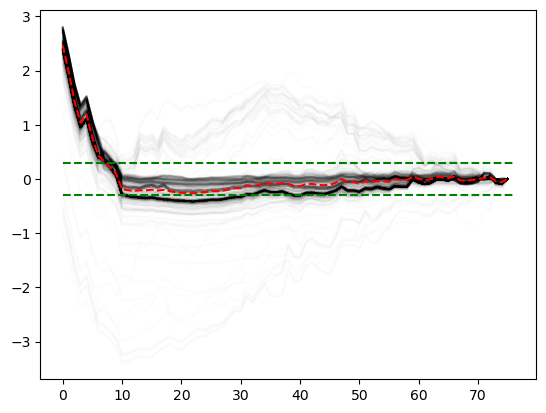

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f93e898d9a0>

In [551]:
for i in 1:n_seq
    plt.plot(cde_incr[site,:,i], alpha = 0.01, color = "black")
end
plt.plot(mean(cde_incr[site,:,:], dims = 2),linestyle = "--", color = "red")
plt.plot([0,76], [0.3,0.3], linestyle = "--", color = "green")
plt.plot([0,76], [-0.3,-0.3], linestyle = "--", color = "green")


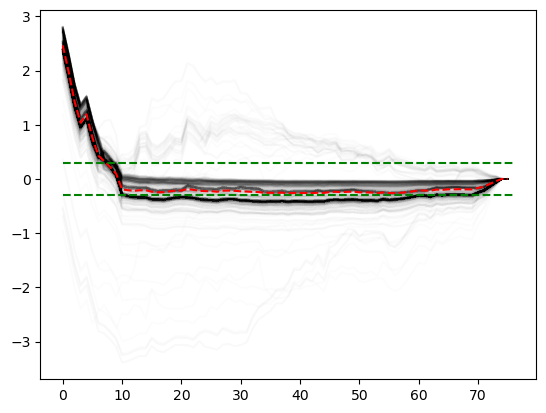

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f93eff35e80>

In [537]:
for i in 1:n_seq
    plt.plot(cde_incr[site,:,i], alpha = 0.01, color = "black")
end
plt.plot(mean(cde_incr[site,:,:], dims = 2),linestyle = "--", color = "red")
plt.plot([0,76], [0.3,0.3], linestyle = "--", color = "green")
plt.plot([0,76], [-0.3,-0.3], linestyle = "--", color = "green")


## When is it converging?

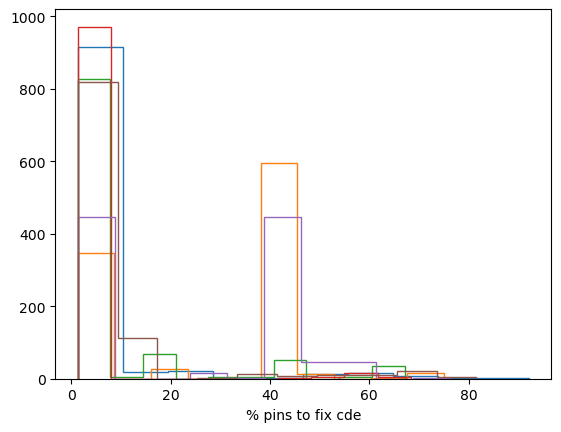

PyObject Text(0.5, 24.0, '% pins to fix cde')

In [50]:
for site in epist_ord[end-5:end]
    plt.hist(abund[site, :], histtype= "step")#color=PyPlot.ColorMap("viridis")(epist_score[site]))
end
plt.xlabel("% pins to fix cde")


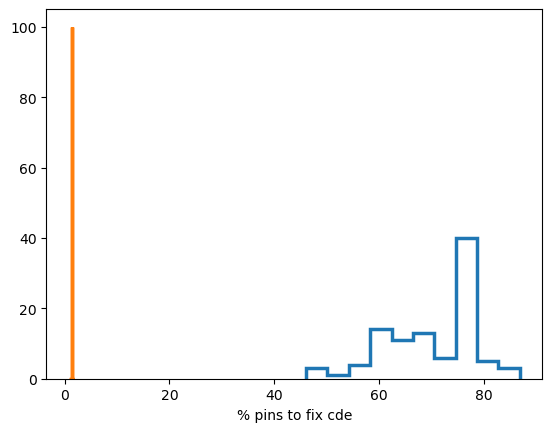

In [66]:
site = 48
n = 100
order = sortperm(chosen_cdes[:,site], rev  = false)[1:n]
plt.hist(abund[site, order], histtype= "step", linewidth = 2.5, label = "low CDE (top 100)")
order = sortperm(chosen_cdes[:,site], rev  = true)[1:n]
plt.hist(abund[site, order], histtype= "step", linewidth = 2.5, label = "high CDE (top 100)")
plt.xlabel("% pins to fix cde")
savefig("../site$(site)_hist_abund.png")

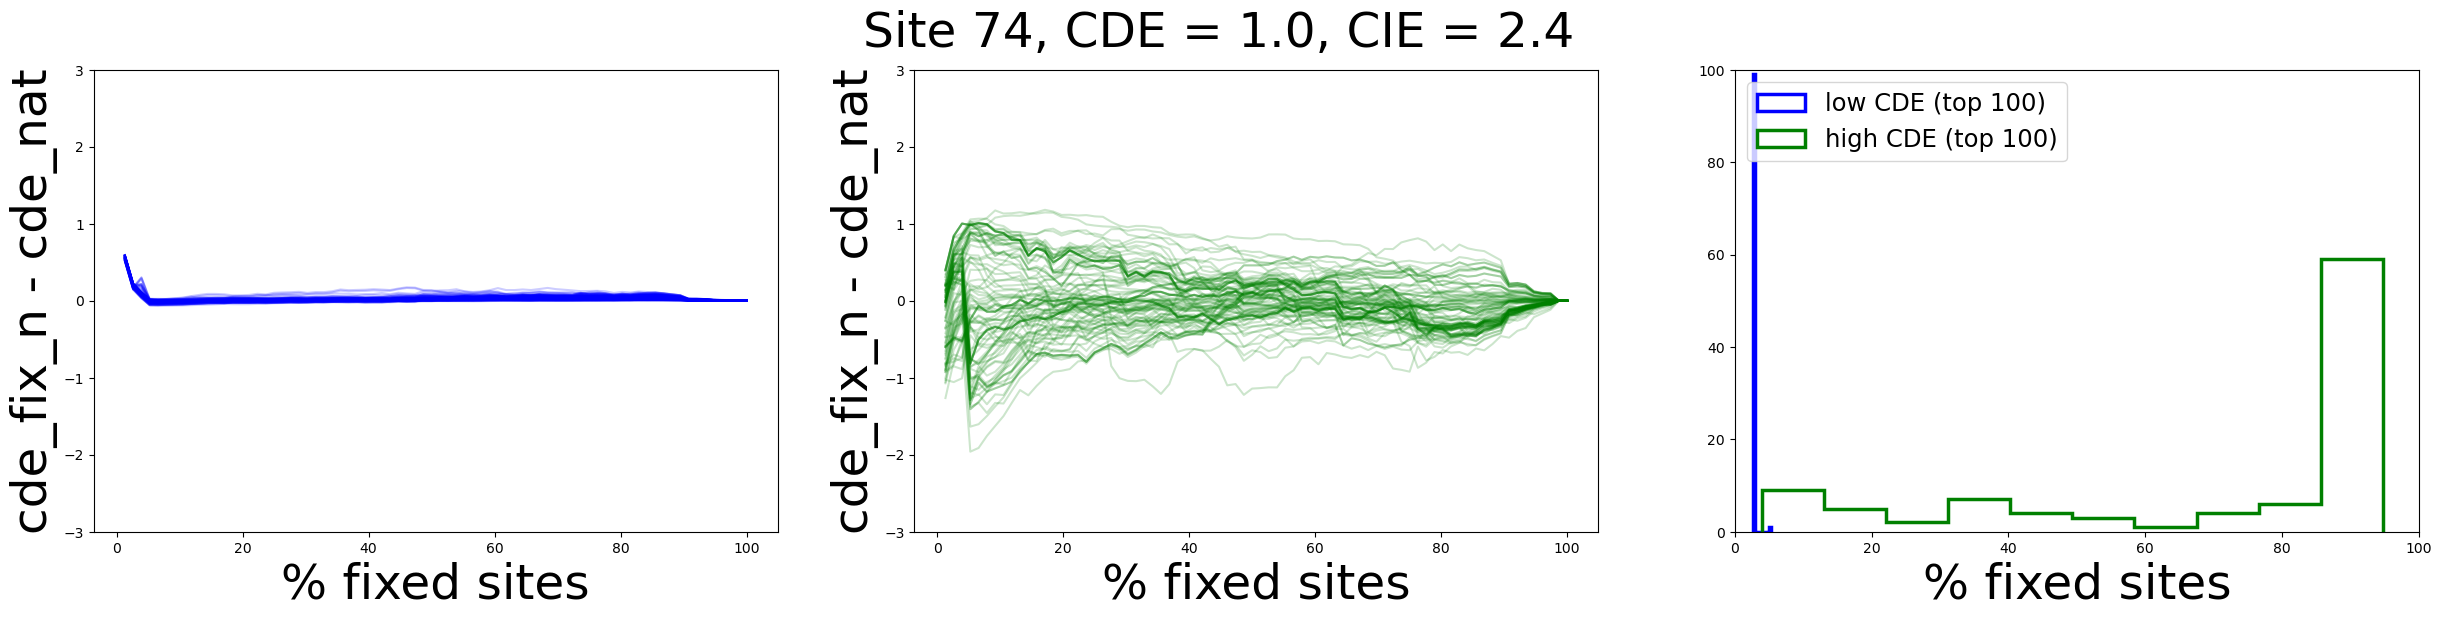

In [115]:
site = 74
n = 100

ticks_font = 25
axis_font = 35

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(6)
fig.set_figwidth(30)
order = sortperm(chosen_cdes[:,site], rev  = false)[1:n]
for s in order
    ax1.plot([i for i in 1:76] .* 100 ./ 76, cde_incr[site, :, s], alpha = 0.2, color = "blue")
end

ax3.hist(abund[site, order], histtype= "step", linewidth = 2.5, color = "blue", 
    label = "low CDE (top 100)")

order = sortperm(chosen_cdes[:,site], rev  = true)[1:n]
for s in order
    ax2.plot([i for i in 1:76] .* 100 ./ 76, cde_incr[site, :, s], alpha = 0.2, color = "green")
end

ax3.hist(abund[site, order], histtype= "step", linewidth = 2.5, 
    label = "high CDE (top 100)", color = "green")

ax1.set_xlabel("% fixed sites", fontsize=axis_font)
ax1.set_ylabel("cde_fix_n - cde_nat", fontsize=axis_font) 
ax1.set_ylim(-3.,3.)

ax2.set_xlabel("% fixed sites", fontsize=axis_font)
ax2.set_ylabel("cde_fix_n - cde_nat", fontsize=axis_font) 
ax2.set_ylim(-3.,3.)

ax3.set_xlabel("% fixed sites",fontsize=axis_font)
ax3.set_xlim(0, 100)
ax3.set_ylim(0, 100)

ax3.legend(loc = "upper left", fontsize = axis_font /2)

fig.suptitle("Site $(site), CDE = $(round(m_cde_nat[site], digits = 1)), CIE = $(round(entr_nat[site], digits = 1))", 
    fontsize=axis_font)

savefig("../site$(site)_lowhigh_cde.png")


In [276]:
## how to use PCA
path_msa = 
proj, (PC1, PC2) = perform_pca(path_msa)

plot_in_pc_space(proj[1],proj[2], nbins=60) #plotta tutte le sequenze su cui hai fatto PCA

wt_proj = get_projection((PC1,PC2), seq_wt)
s_proj_x = [wt_proj[1][1]] #coordinate della sequenza wt nello spazio PC
s_proj_y = [wt_proj[2][1]]

LoadError: UndefVarError: `perform_pca` not defined